In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import special, integrate

sys.path.insert(0, '/home/aew492/CFE_gradients')
from generate_mock_list import MockSet
from grad_tools import load_suave_amps

## functions

In [17]:
def grad_precision(mockset, basis='bao_iterative'):
    amps = load_suave_amps(mockset, basis=basis).T # (nmocks,4)
    grads_rec = amps[1:]/amps[0]  # (3,nmocks)
    grads_std = np.var(grads_rec, axis=1)
    return grads_std

In [32]:
# ** predicted variance in the 2pcf at a certain length scale r (Roman's equation)
def xi_var_pred(r, V, n, k, Pk, nk=1000):

    # interpolate between the discrete (k, Pk) values to get a finer scale for integration
    kfine = np.linspace(min(k), max(k), nk)
    Pkfine = np.interp(kfine, k, Pk)
    
    # multiplicative constant
    const = 1 / (2*np.pi*V)

    # function of k that we want to integrate
    def k_func(k, Pk):
        return (k/r) * (Pk+(1/n))**2 * (special.jv(1/2, k*r))**2

    # construct our array, and integrate using trapezoid rule
    k_func_arr = np.array([k_func(k, Pkfine[i]) for i, k in enumerate(kfine)])
    trapz = integrate.trapz(k_func_arr, x=kfine)

    return const*trapz

In [33]:
def xi_var_pred_grad(r, V, n, k, Pk, nk=1000):
    xi_var_pred_nograd = xi_var_pred(r, V, n, k, Pk, nk=nk)
    return xi_var_pred_nograd * V**(-1/3)  # extra factor of 1/L

## input power spectra

In [6]:
# we want to use our fiducial mock set to start so,
L = 750
n = '2e-4'
As = 2

In [7]:
# for As2x
PkG_fn = f'/scratch/ksf293/mocks/lognormal/inputs/cat_L{int(L)}_n{n}_z057_patchy_As{As}x_pkG.dat'
kG, PkG = np.loadtxt(PkG_fn).T

Text(0, 0.5, 'P(k)')

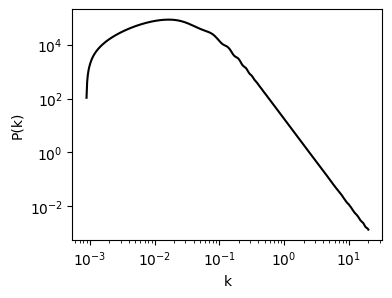

In [8]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(kG, PkG, color='k')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel('P(k)')

## $\sigma^2_\xi (L)$: precision of grad. recovery as a function of boxsize

### simulated results

In [22]:
# mock parameters
Ls = [500, 750] #, 1000, 1500]
ms = [0.333, 0.5] #, 0.667, 1]
grad_dim = 3
b = 0.5
n = '2e-4'
As = 2
nmocks = 1000

In [23]:
stds = np.empty((len(Ls),3))
for i, L in enumerate(Ls):
    mockset = MockSet(L, n, rlzs=rlzs)
    mockset.add_gradient(grad_dim, ms[i], b, same_dir=False)
    stds[i] = grad_precision(mockset)

Text(0.5, 1.0, '')

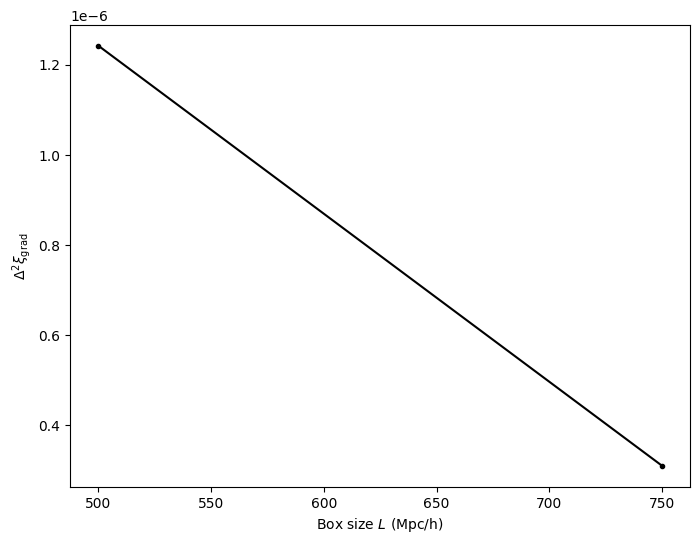

In [28]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(Ls, stds[:,0], marker='.', color='k', label='x')

ax.set_xlabel('Box size $L$ (Mpc/h)')
ax.set_ylabel(r'$\Delta^2 \xi_\mathrm{grad}$')
ax.set_title('')

## $\sigma^2_\xi (n)$: precision of grad. recovery as a function of number density 

### simulated results

In [31]:
# mock parameters
L = 750
m = 0.5
ns = ['1e-4', '2e-4', '4e-4']
As = 2
nmocks = 1000